# Validation Test Set을 만든다

In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
from torch.utils.data import Dataset

import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer

from sklearn.model_selection import train_test_split

from collections import Counter

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data = pd.read_csv('../../data/train.csv')

## 노이즈 정도 수치화

In [3]:
import spacy
import string
import re

# 한국어 모델 로드
nlp = spacy.load("ko_core_news_sm")

def noise_score_spacy(text):
    doc = nlp(text)
    
    # 단어 수
    word_count = len(doc)
    
    # 노이즈 관련 점수 계산
    special_char_count = sum(1 for char in text if char in string.punctuation)
    non_korean_char_count = len(re.findall(r'[a-zA-Z0-9]', text))
    short_word_count = sum(1 for token in doc if len(token.text) == 1)
    
    # 한글 자모 분리 현상 감지
    separated_hangul_count = len(re.findall(r'[ㄱ-ㅎㅏ-ㅣ]', text))
    
    # 불규칙한 대소문자 변경 감지
    irregular_case_count = sum(1 for i in range(1, len(text)) if text[i-1].islower() and text[i].isupper())
    
    # 품사 태그 다양성 (낮을수록 노이즈 가능성 높음)
    pos_counts = {}
    for token in doc:
        pos_counts[token.pos_] = pos_counts.get(token.pos_, 0) + 1
    pos_diversity = len(pos_counts)
    
    # 노이즈 점수 계산
    noise_score = (
        (special_char_count * 2) +
        (non_korean_char_count * 1.5) +
        (short_word_count * 1.5) +
        (separated_hangul_count * 3) +
        (irregular_case_count * 2)
    ) / max(1, word_count)  # 단어 수로 나누어 정규화
    
    # 품사 다양성에 따른 보정 (다양성이 낮을수록 점수 증가)
    diversity_factor = max(1, 5 - pos_diversity) / 5
    noise_score *= (1 + diversity_factor)
    
    # 최종 점수 범위 조정 (0-100 사이)
    final_score = min(100, max(0, noise_score * 20))
    
    return final_score

data['noise_score'] = data['text'].apply(noise_score_spacy)

In [49]:
data.head()

,ID,text,target,noise_score,label_quality
0,ynat-v1_train_00000,정i :파1 미사z KT( 이용기간 2e 단] Q분종U2보,4,58.909091,0.215058
1,ynat-v1_train_00001,K찰.국DLwo 로L3한N% 회장 2 T0&}송=,3,100.000000,0.110188
2,ynat-v1_train_00002,"m 김정) 자주통일 새,?r열1나가야1보",2,61.714286,0.271684
3,ynat-v1_train_00003,갤노트8 주말 27만대 개통…시장은 불법 보조금 얼룩,5,18.666667,0.270392
4,ynat-v1_train_00004,pI美대선I앞두고 R2fr단 발] $비해 감시 강화,6,63.000000,0.275686


In [4]:
# data[data.noise_score <= 30]  # 얼추 안전 (1086개)
# data[(data.noise_score > 30) & (data.noise_score <= 70)]  # 적당 노이즈800개
# data[data.noise_score > 70]  # 위험 (911개)

## 라벨 품질 수치화 (cleanlab)
- k-fold cross-validation을 통해 예측 확률을 생성하고
- cleanlab을 사용해 라벨 문제를 탐색하여 이상 없는 데이터만을 최종적으로 선택

In [7]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import KFold

import torch
from torch.utils.data import Dataset, DataLoader
import evaluate
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from transformers import DataCollatorWithPadding, TrainingArguments, Trainer

from cleanlab.filter import find_label_issues

SEED = 456
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_name = 'klue/bert-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
os.environ['WANDB_DISABLED'] = 'true'

class BERTDataset(Dataset):
    def __init__(self, data, tokenizer):
        input_texts = data['text']
        targets = data['target']
        self.inputs = []; self.labels = []
        for text, label in zip(input_texts, targets):
            tokenized_input = tokenizer(text, padding='max_length', max_length=50, truncation=False, return_tensors='pt')
            self.inputs.append(tokenized_input)
            self.labels.append(torch.tensor(label))

    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs[idx]['input_ids'].squeeze(0),
            'attention_mask': self.inputs[idx]['attention_mask'].squeeze(0),
            'labels': self.labels[idx].squeeze(0)
        }

    def __len__(self):
        return len(self.labels)

f1 = evaluate.load('f1')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average='macro')

# K-Fold Cross Validation 설정
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=SEED)

# Cross Validation을 통해 예측 확률 구하기
all_pred_probs = np.zeros((len(data), 7))  # num_labels = 7

for fold, (train_idx, val_idx) in enumerate(kf.split(data)):
    print(f"Training fold {fold + 1}/{k_folds}...")
    
    # Train/Validation split
    train_data = data.iloc[train_idx].reset_index(drop=True)
    val_data = data.iloc[val_idx].reset_index(drop=True)
    
    # Dataset 준비
    train_dataset = BERTDataset(train_data, tokenizer)
    val_dataset = BERTDataset(val_data, tokenizer)
    
    # Trainer 설정
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=7).to(DEVICE)
    training_args = TrainingArguments(
        output_dir=f'./results_{fold}',
        overwrite_output_dir=True,
        do_train=True,
        do_eval=True,
        do_predict=True,
        logging_strategy='epoch',
        eval_strategy='epoch',
        save_strategy='epoch',
        logging_steps=100,
        # eval_steps=100,
        # save_steps=100,
        save_total_limit=1,
        learning_rate= 2e-05, # 가능
        adam_beta1 = 0.9, # 불가
        adam_beta2 = 0.999, # 불가
        adam_epsilon=1e-08, # 불가
        weight_decay=0.01, # 불가
        lr_scheduler_type='linear', # 불가
        per_device_train_batch_size=32, # 가능
        per_device_eval_batch_size=32, # 32인 건 이유가 있다.
        num_train_epochs=2, # 불가
        # load_best_model_at_end=True,
        metric_for_best_model='eval_f1',
        greater_is_better=True,
        seed=SEED, # 불가? 가급적 건드리지 말기
    )
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=DataCollatorWithPadding(tokenizer),
        compute_metrics=compute_metrics,
    )
    
    # 모델 학습
    trainer.train()
    
    # Validation 데이터에 대해 예측 확률 계산
    val_loader = DataLoader(val_dataset, batch_size=16)
    model.eval()
    pred_probs = []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Evaluating fold {fold + 1}"):
            inputs = {k: v.to(DEVICE) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits
            probs = torch.nn.functional.softmax(logits, dim=1)
            pred_probs.extend(probs.cpu().numpy())
    
    # 예측 확률 저장
    all_pred_probs[val_idx] = np.array(pred_probs)

Training fold 1/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.940700,1.843440,0.279222
2,1.751200,1.755848,0.353838


Evaluating fold 1: 100%|██████████| 35/35 [00:00<00:00, 73.40it/s]


Training fold 2/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.899500,1.762369,0.360289
2,1.666000,1.674367,0.371088


Evaluating fold 2: 100%|██████████| 35/35 [00:00<00:00, 73.43it/s]


Training fold 3/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.913100,1.813910,0.275158
2,1.680600,1.715980,0.369910


Evaluating fold 3: 100%|██████████| 35/35 [00:00<00:00, 72.75it/s]


Training fold 4/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.904700,1.786705,0.325686
2,1.678600,1.699760,0.381468


Evaluating fold 4: 100%|██████████| 35/35 [00:00<00:00, 72.99it/s]


Training fold 5/5...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,F1
1,1.914200,1.809073,0.311593
2,1.678700,1.718787,0.357789


Evaluating fold 5: 100%|██████████| 35/35 [00:00<00:00, 73.12it/s]


In [8]:
# cleanlab을 사용하여 라벨 이슈 탐색
ordered_label_issues = find_label_issues(
    labels=data['target'].values,
    pred_probs=all_pred_probs,
    return_indices_ranked_by='self_confidence',
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [9]:
from cleanlab.rank import get_label_quality_scores

# 라벨 품질 점수 계산
label_quality_scores = get_label_quality_scores(
    labels=data['target'].values,
    pred_probs=all_pred_probs
)

# clean_data에 'label_quality' 열 추가
data['label_quality'] = label_quality_scores

#### 라벨 매핑 정보 (추측)
- 0: 생활문화
- 1: 스포츠
- 2: 정치
- 3: 사회
- 4: IT과학
- 5: 경제
- 6: 세계

In [48]:
data[(data.target == 0) & (data.noise_score < 30)].sort_values(by='label_quality', ascending=False).head(3)

,ID,text,target,noise_score,label_quality
1532,ynat-v1_train_01532,기다렸다 눈과 추위야…강원 스키장 개장 준비 분주,0,4.0,0.313370
1747,ynat-v1_train_01747,대구·경북 수은주 뚝…내일 새벽 산지엔 서리·얼음,0,14.0,0.283421
2367,ynat-v1_train_02367,당신의 스무살 생일은 어땠나요…무라카미 하루키 버스데이 걸,0,8.0,0.277331


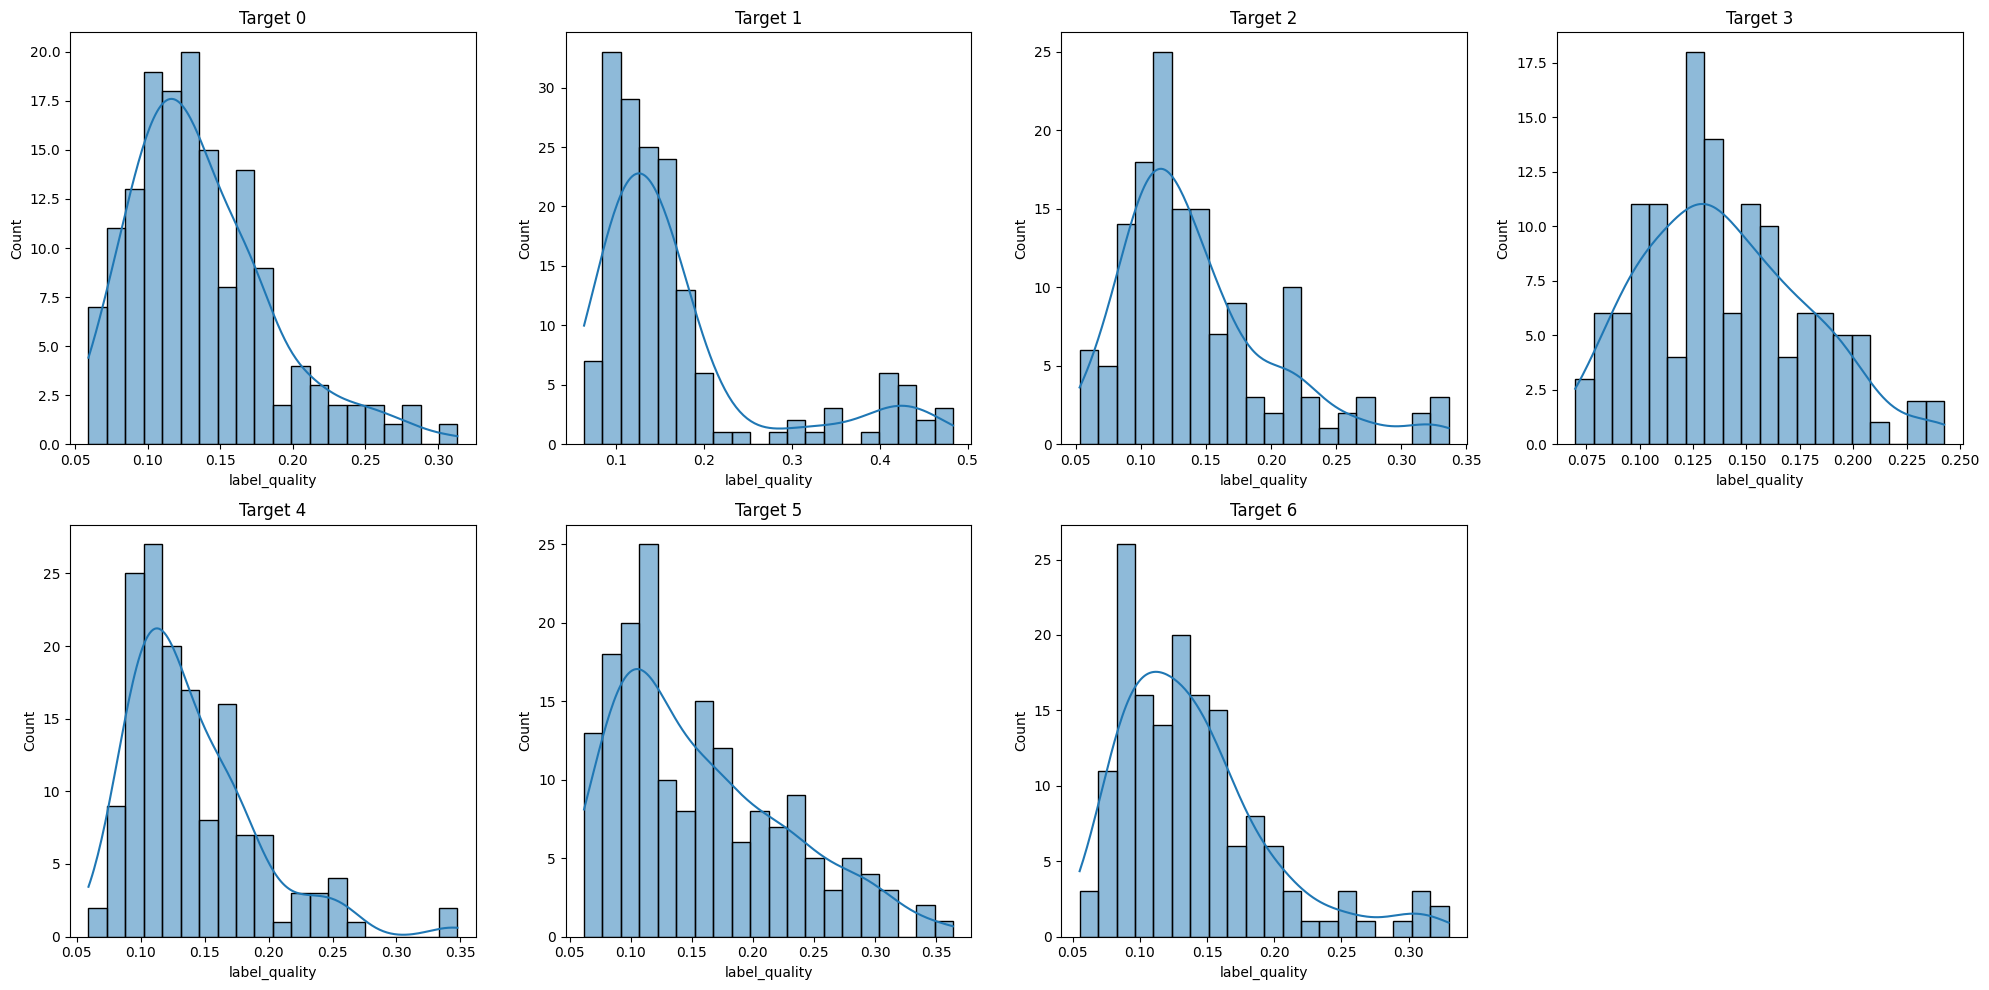

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_clear = data[data.noise_score < 30]

# 히스토그램 생성
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for target in range(7):
    sns.histplot(data_clear[data_clear['target'] == target]['label_quality'], bins=20, kde=True, ax=axes[target])
    axes[target].set_title(f"Target {target}")

# 빈 subplot 숨김
axes[7].axis('off')

plt.tight_layout()
plt.show()

In [36]:
# 각 target별로 상위 label_quality 데이터를 추출
validation_data = pd.concat([
    data_clear[data_clear['target'] == target].nlargest(20, 'label_quality') for target in range(7)
], ignore_index=True)

In [47]:
validation_data[validation_data.target == 5].head(3)

,ID,text,target,noise_score,label_quality
100,ynat-v1_train_02664,한투증권 빙그레 폭염에 빙과 수요 증가…매수,5,4.500000,0.363844
101,ynat-v1_train_01039,특징주 삼성SDI 실적 개선에 강세종합,5,21.600000,0.345429
102,ynat-v1_train_01805,하나금투 서울반도체 올해 실적 상저하고…매수,5,5.142857,0.336467


In [43]:
train_data = data[~data.ID.isin(validation_data.ID)]

In [46]:
train_data.to_csv("../../datasets/v0.0.2/train.csv", index=False)
validation_data.to_csv("../../datasets/v0.0.2/validation.csv", index=False)